# Loading flipkart reviews dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/flipkart_reviews_dataset.csv')
print(df.head())


         product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating            summary  \
0       5  Terrific purchase   
1       5  Terrific purchase   
2       5             Super!   
3       5             Super!   
4       5  Terrific purchase   

                                              review       location  \
0  1-more flexible2-bass is very high3-sound clar...        Shirala   
1     Super sound and good looking I like that prize  Visakhapatnam   
2  Very much satisfied with the device at this pr...      Kozhikode   
3  Nice headphone, bass was very good and sound i...          Jaora   
4  Soun

In [2]:
print(df.columns)

Index(['product_id', 'product_title', 'rating', 'summary', 'review',
       'location', 'date', 'upvotes', 'downvotes'],
      dtype='object')


# PREPROCESSING (CREATING LABEL COLUMN)

In [5]:
def assign_sentiment(rating):
    if rating >= 3:
        return 1  # Positive
    elif rating <= 2:
        return 0  # Negative
    else:
        return None
df['label'] = df['rating'].apply(assign_sentiment)

df['label'] = df['label'].astype(int)

print(df[['review', 'rating', 'label']].tail())


                                                 review  rating  label
9369  this head phnes give good base in pluged ears ...       4      1
9370  This so far is one of the best headphones I've...       5      1
9371  I am a BASS LOVER and all others like me read ...       4      1
9372  After use of one month........ It is an excell...       5      1
9373  Excellent quality. it works so good. super hap...       5      1


# LOADING PRETRAINED BERT

In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(review):
    return tokenizer(review, padding='max_length', truncation=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:

tokenized_data = df['review'].apply(tokenize_function)
input_ids = [token['input_ids'] for token in tokenized_data]
attention_masks = [token['attention_mask'] for token in tokenized_data]
df['input_ids'] = input_ids
df['attention_masks'] = attention_masks
print(df[['review', 'label', 'input_ids', 'attention_masks']].head())


                                              review  label  \
0  1-more flexible2-bass is very high3-sound clar...      1   
1     Super sound and good looking I like that prize      1   
2  Very much satisfied with the device at this pr...      1   
3  Nice headphone, bass was very good and sound i...      1   
4  Sound quality super battery backup super quali...      1   

                                           input_ids  \
0  [101, 1015, 1011, 2062, 12379, 2475, 1011, 332...   
1  [101, 3565, 2614, 1998, 2204, 2559, 1045, 2066...   
2  [101, 2200, 2172, 8510, 2007, 1996, 5080, 2012...   
3  [101, 3835, 2132, 9864, 1010, 3321, 2001, 2200...   
4  [101, 2614, 3737, 3565, 6046, 10200, 3565, 373...   

                                     attention_masks  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1,

# SPLITTING DATASET

In [10]:
from sklearn.model_selection import train_test_split
import torch


train_inputs, val_inputs, train_labels, val_labels = train_test_split(df['input_ids'], df['label'], test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(df['attention_masks'], test_size=0.2, random_state=42)

# Convert the inputs to lists of tensors

train_inputs = torch.tensor(train_inputs.tolist())
val_inputs = torch.tensor(val_inputs.tolist())
train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())
train_masks = torch.tensor(train_masks.tolist())
val_masks = torch.tensor(val_masks.tolist())


In [9]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT pre-trained model for binary classification (positive/negative)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# CREATING DATALOADER

In [11]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
train_dataloader = DataLoader(train_data, batch_size=16)
val_dataloader = DataLoader(val_data, batch_size=16)


TRAINING

In [12]:
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


loss_fn = CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Training loss: {avg_train_loss}")


Epoch 1, Training loss: 0.16420393895047405
Epoch 2, Training loss: 0.08296932063897919
Epoch 3, Training loss: 0.05250694122262189


# EVALUATING

In [13]:
model.eval()

total_eval_accuracy = 0
total_eval_loss = 0

for batch in val_dataloader:
    batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
    loss = outputs.loss
    logits = outputs.logits

    total_eval_loss += loss.item()

    preds = torch.argmax(logits, dim=1).flatten()
    accuracy = (preds == batch_labels).cpu().numpy().mean()
    total_eval_accuracy += accuracy

avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
avg_val_loss = total_eval_loss / len(val_dataloader)

print(f"Validation accuracy: {avg_val_accuracy}")
print(f"Validation loss: {avg_val_loss}")


Validation accuracy: 0.96875
Validation loss: 0.1344353343413042


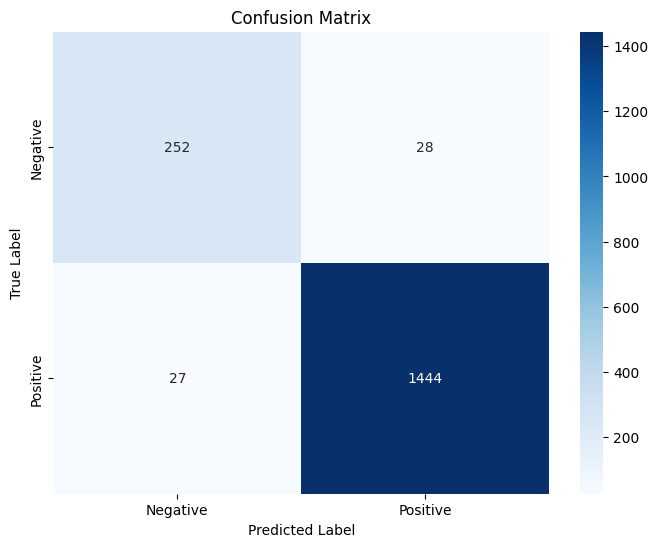

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on the validation set
model.eval()
predictions = []
true_labels = []

for batch in val_dataloader:
    batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)

    preds = torch.argmax(outputs.logits, dim=1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(batch_labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# PREDICTION

In [15]:
def predict_sentiment(review_text):
    inputs = tokenizer(review_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label


In [16]:
# Example reviews
example_reviews = [
    "This product is amazing! It exceeded my expectations.",
    "The product quality is horrible. I will never buy from this brand again.",
    "It's okay, not too bad but not too good either.",
    "Excellent! Loved it, and the delivery was super fast.",
    "Worst product I have ever purchased."
]

for review in example_reviews:
    sentiment = predict_sentiment(review)
    sentiment_text = "Positive" if sentiment == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment_text}\n")


Review: This product is amazing! It exceeded my expectations.
Predicted Sentiment: Positive

Review: The product quality is horrible. I will never buy from this brand again.
Predicted Sentiment: Negative

Review: It's okay, not too bad but not too good either.
Predicted Sentiment: Positive

Review: Excellent! Loved it, and the delivery was super fast.
Predicted Sentiment: Positive

Review: Worst product I have ever purchased.
Predicted Sentiment: Negative

